# Assignment 1a: Introduction to Heuristic-based Graph Search

Welcome to AI4Sec! Throughout this semester you'll receive assignments like this one that serve as interactive tools for learning new techniques and applying them to complete exercises. It is very important that you ***READ*** these assignments in their entirety, as they are designed to serve as both instruction and exercise. Later in the semester, these assignments will be completed in groups, but are individual assignments for now. 

In this assignment, you'll be introduced to graph search by playing the game *Minesweeper* (or rather, writing code that plays Minesweeper). You'll then use a neuroevolution library, *evosax*, to create AI agents that play Minesweeper. If you don't fancy yourself as an AI person, no need to worry! This assignment assumes no prerequisite AI knowledge and is focused on showing you how to use a high-level library and high-level concepts that will come into play in later assignments (which have more security components).

## On Jupyter Notebooks

Jupyter notebooks (like the one you're reading now) are basically interactive Python scripts that support Markdown-formatted text and execution of individual cells of code. This provides the flexibility to evaluate code cells multiple times, execute cells in an arbitrary order, or skip the execution of cells entirely. As is the case with Python as a language, this flexibility enables intentional and unintentional abuse and can result in some fairly unintelligible code. Here are some guidelines and tips on notebook use:
* Unless stated otherwise, it's good to assume that you should execute all code cells in order, from top to bottom.
* Executing a cell multiple times is fine and is very useful in allowing for multiple attempts at completing a step without re-running the entire notebook.
* You may see unusual `del` statements in provided code to help prevent/discourage global variable abuse. You are not required to follow this practice in your own code (though still avoid abuse of global variables).
* Output from cell execution (e.g., from `print`) is saved within the notebook and can increase notebook file size to the point of becoming unstable (e.g., unable to load due to Jupyter, unable to load due to your browser, unable to upload to GitHub). Try not to output an excessive amount to avoid this.
* Jupyter saves execution output in the notebook between sessions (if the notebook was saved), but values in memory are not saved between sessions.
* Use `shift + enter` to execute the current cell and move to the next cell.
* Use `ctrl + enter` to execute the current cell without moving to the next cell (i.e., doing this multiple times will repeatedly evaluate the same cell).

To start the assignment, execute the following cell.

In [ ]:
!pip install matplotlib
!pip install git+https://github.com/RobertTLange/evosax.git@main

import random
import statistics
import matplotlib.pyplot as plt
import matplotlib as mpl
import evosax
from evosax import ParameterReshaper, FitnessShaper
import jax
import jax.numpy as jnp
from flax import linen as nn
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots

print('The first cell has been executed!')

## Minesweeper

Minesweeper is a classic computer game that commonly comes preinstalled in operating systems. If you're unfamiliar with Minesweeper, or haven't thought about it in a while, I recommend searching `minesweeper` on Google and playing the interactive game Google hosts in the search results.

The game is simple:
* The game board is a grid of covered cells.
* Selecting a cell reveals the contents of that cell.
* The goal is to reveal all cells except those containing mines.
* If a cell containing a mine is selected, the game is over.
* If a cell does not contain a mine, it contains a number indicating the count of adjacent/diagonal cells containing mines.
* Selecting a cell with a value of 0 reveals all adjacent/diagonal cells without mines and this cascades through newly-revealed cells with a value of 0.
* Player score is calculated based on the number of non-mine cells revealed.
* To simplify implementation, the game board is implemented as a toroid (e.g., cells on either end of a row are treated as adjacent)

### Minesweeper as Graph Search

Graph search has a straightforward application to network traversal/enumeration that we'll explore in later assignments. For now, though, we'll treat Minesweeper as a graph search problem for the sake of learning graph search without getting too boring. Basically, we want to enumerate the entire game board except for the cells containing mines. We'll modify the game slightly to make it analogous to graph search: 
1. we start by specifying the first cell to select at the start of the game,
2. we will only select cells that are adjacent/diagonal to already revealed cells.

We can now say that selecting a cell is akin to visiting a node in a graph, which reveals new edges to other nodes. As edges are revealed, we discover more nodes to visit and the edges between nodes can provide information to guide our movement. Our goal, then, is to visit all nodes in the graph except for those containing mines. This goal is similar to network defense scenarios in which an attacker wants to enumerate all machines on a network except for those that would trigger the suspicions of an administrator.

### The Minesweeper Environment
For this assignment you'll be provided with an implementation of Minesweeper containing the modified version of the game described above. This implementation closely resembles the Gym environments popularized by OpenAI. Execute the code cell below to import the `MinesweeperGame` class, as well as a helper function for rendering the game using ASCII art, and to define an instance of a Minesweeper problem (a 2D binary array indicating the placement of mines). We'll also instantiate an environment object for use in consequent code cells.

In [ ]:
from minesweeper import MinesweeperGame, render_map

beginner_board = [
    [0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,1],
    [0,0,0,1,0,1,0,0,0],
    [0,1,0,0,0,0,0,0,1],
    [0,0,1,0,0,0,0,1,1],
    [0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0]]

env = MinesweeperGame(beginner_board, enforce_reachability=True)

Notice that we passed a named argument `enforce_reachability` in the previous cell. Setting this value to `True` means that score will only be calculated using the percentage of *reachable* non-mine cells.

In the next cell, we'll call `env.reset()` to receive three variables:
* `obs` - a list of observations, each corresponding to an available action
* `score` - the score of the game, calculated as the portion of revealed non-mine cells (a float between 0 and 1)
* `done` - a boolean value of `True` if the game is complete or `False` otherwise

We'll also visualize the start of the game as a human Minesweeper player would see it. Note that because we're using a modified version of Minesweeper, the game begins having already selected the cell at a predetermined starting location (by default, the middle of the map).

In [ ]:
obs, score, done = env.reset()

print(f'Available actions: {len(obs)}')
print(f'Score: {score}')
print(f'Done? {done}')

print('\nInitial game state')
render_map(env.player_map, compact=False)

del env, obs, score, done # To discourage haphazard copypasta

When a cell is selected and new reachable locations are revealed, an action for selecting the newly-reachable cell is added to an internal list within the `MinesweeperGame` instance. We can infer the number of available actions by the length of `obs`. To make an action, we select the index of the action we'd like to make and pass that index to a `step` function, which makes the action and returns updated `obs`, `score`, and `done` values. This interface and representation isn't terribly human-readable, but it allows us to define strategies for playing the game with relative ease. For example, because the internal list of possible actions maintains the order in which actions became available, we can implement a breadth-first graph search of the minesweeper map by always selecting actions index `0`. Similarly, depth-first graph search can be implemented by always selecting the last available index.

The following cell demonstrates a function that plays a game using an agent that selects random actions. You are encouraged to execute this cell multiple times in order to observe the various-quality solutions this simple agent is able to produce.

In [ ]:
def random_agent(game_map, **kwargs):
    env = MinesweeperGame(game_map, **kwargs)
    obs, score, done = env.reset()
    while not done:
        action = random.randrange(len(obs)) # select a random action
        obs, score, done = env.step(action)
    return score, env.player_map

# Evalute our simple agent
score, final_map = random_agent(beginner_board, enforce_reachability=True)

print(f'Final agent score: {score}')
print('Final game state:')
render_map(final_map, compact=False)

del score, final_map # To discourage haphazard copypasta

## Random-Action Agent
Observing individual games played by a random-action agent is typically interesting, but to gain meaningful insight on the performance of a stochastic agent such as this, we must sample performance many times. Execute the following cell to sample the performance of the random-action agent.

In [ ]:
def sample_random_agent(samples, game_map, **kwargs):
    scores = []
    best_score = 0
    best_solution = None
    
    for _ in range(samples):
        score, solution = random_agent(game_map, **kwargs)
        if best_solution == None or score > best_score:
            best_solution = solution
            best_score = score
        scores.append(score)
    return scores, best_solution

beginner_scores, best_solution = sample_random_agent(5000, beginner_board, enforce_reachability=True)

print(f'Minimum score: {min(beginner_scores)}')
print(f'Average score (stdev): {statistics.mean(beginner_scores)} ({statistics.stdev(beginner_scores)})')
print(f'Maximum score: {max(beginner_scores)}')
print('Best final game state')
render_map(best_solution, compact=False)

del best_solution # To discourage haphazard copypasta

****Thought Exercise:**** Consider whether or not you expected the performance of the random-action agent. Do you expect to observe the same behavior on more difficult problem instances? 

Execute the following cell to explore the performance of the random-action agent on a problem instance of intermediate difficulty.

In [ ]:
intermediate_board = [
    [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0],
    [1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1],
    [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1],
    [1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
    [0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0],
    [0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0],
    [1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0],
    [1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
]

intermediate_scores, best_solution = sample_random_agent(5000, intermediate_board, enforce_reachability=True)

print(f'Minimum score: {min(intermediate_scores)}')
print(f'Average score (stdev): {statistics.mean(intermediate_scores)} ({statistics.stdev(intermediate_scores)})')
print(f'Maximum score: {max(intermediate_scores)}')
print('Best final game state')
render_map(best_solution, compact=False)

del best_solution # To discourage haphazard copypasta

We expect that you observe meaningfully different mean and maximum scores with a standard deviation that alludes to a significantly different distribution of scores. In other words, the random-action agent probably had a more difficult time with the harder map and we can begin to see the waning effectiveness of this simple strategy. Visualize the distribution of scores produced by the random-action agent on different problem difficulties by executing the next cell. 

****Thought Exercise:**** Consider whether or not you think the maximum score observed in each difficulty is an outlier or representative of the typical performance of the random-action agent.

In [ ]:
# visualize random agent data with boxplot
fig, ax = plt.subplots()
boxplot = ax.boxplot([beginner_scores, intermediate_scores], labels=['Beginner', 'Intermediate'])
ax.set_title('Random-Action Agent Performance')
ax.set_xlabel('Minesweeper Difficulty')
ax.set_ylabel('Score')
plt.ylim(bottom=0.0, top=1.0)
plt.show()

Now that we've explored the simple strategy of randomly selecting actions to solve Minesweeper, consider the following:
1. Randomly selecting actions is a powerful strategy for beginner Minesweeper. In fact, it's probably a waste of energy/effort to implement a more complex solver if all you have are beginner problem instances.
2. The likelihood of encountering a decent solution by randomly selecting actions seems to decrease as difficulty increases.
3. The performance of the random-action agent, regardless of quality, is inherently inconsistent due to the agent being stochastic.

To address points 2 and 3, we'll begin by creating agents with more consistent performance. To do this, we'll implement agent strategies that are deterministic. Note, however, that this requires a trade off: deterministic agents need only play a single game\* of Minesweeper to yield their best possible solution to a problem instance, but it can often be the case that the agent strategy needs greater complexity to compete with the random-action agent. To begin, we'll implement simple deterministic agents employing breadth-first and depth-first search.

\* Provided the game/environment/problem is also deterministic, which is true in the case of our Minesweeper environment.

## Exercise 0
In the following cells, implement breadth-first and depth-first search agents using the provided partial functions. Then, evaluate the cells calling your functions to assess the performance of your agents.

***Hint:*** Your functions should look similar to the `random_agent` function. An approach for implementing breadth-first and depth-first search is described in the earlier text of this notebook.

In [ ]:
def breadth_first_agent(game_map, **kwargs):
    env = MinesweeperGame(game_map, **kwargs)
    obs, score, done = env.reset()
    # Complete the following code
    pass
    
    return score, env.player_map

score, solution = breadth_first_agent(beginner_board, enforce_reachability=True)

mine = True in ['*' in seq for seq in solution]
if not mine and score < 1.0:
    print('Game did not play until completion. Please check your agent.')
else:
    print(f'BFS Agent Score: {score}')
    print('BFS final game state:')
    render_map(solution, compact=False)

In [ ]:
def depth_first_agent(game_map, **kwargs):
    env = MinesweeperGame(game_map, **kwargs)
    obs, score, done = env.reset()
    # Complete the following code
    pass
    
    return score, env.player_map

score, solution = depth_first_agent(beginner_board, enforce_reachability=True)

mine = True in ['*' in seq for seq in solution]
if not mine and score < 1.0:
    print('Game did not play until completion. Please check your agent.')
else:
    print(f'DFS Agent Score: {score}')
    print('DFS final game state:')
    render_map(solution, compact=False)

In [ ]:
bfs_beginner, _ = breadth_first_agent(beginner_board, enforce_reachability=True)
bfs_intermediate, _ = breadth_first_agent(intermediate_board, enforce_reachability=True)

dfs_beginner, _ = depth_first_agent(beginner_board, enforce_reachability=True)
dfs_intermediate, _ = depth_first_agent(intermediate_board, enforce_reachability=True)

print('\t\tBeginner\tIntermediate')
print(f'BFS:\t\t{bfs_beginner:.6f}\t{bfs_intermediate:.6f}')
print(f'DFS:\t\t{dfs_beginner:.6f}\t{dfs_intermediate:.6f}')
print(f'Random (avg):\t{statistics.mean(beginner_scores):.6f}\t{statistics.mean(intermediate_scores):.6f}')
print(f'Random (max):\t{max(beginner_scores):.6f}\t{max(intermediate_scores):.6f}')

## Heuristic Search

The strategies explored so far have been very simple: pick the newest, oldest, or a random action at each step of the game. We'll begin to develop more complex strategies by developing heuristics. Simply put, a heuristic (in our context) is a function we use to determine which actions we want to make most given some kind of information regarding each action. For our uses, this function typically returns a value representing how much we want to make each action and we select the action with the highest value.

To put this in context of regular life, a heuristic is akin to a rule of thumb you might use to guide how you approach various problems. Imagine you're trying to get from one place to another via car, but you have to pick when to turn without the assistance of GPS navigation. How would you navigate? If you know the general direction of your destination, you may employ a heuristic of making turns that send you in that direction. If you had a limited-function GPS that only gave you the distance to your destination as measured in a straight line, you might turn in directions that tend to decrease that distance and use that distance as a heuristic.

Back to Minesweeper though: we can express the strategies we've explored thus far as heuristics. Let's say we select the action with the highest value. Breadth-first search can be represented by a heuristic that returns the number of steps since an action first became available (i.e., older actions have a higher value). Depth-first search can be expressed by a heuristic that returns the step count when an action became available (i.e., newer actions have a higher value). And the random-action agent can be expressed by a heuristic that simply returns random numbers for each action at each timestep. In all of these cases, however, the heuristic in question doesn't utilize any information about the state of the game or the cells near where an action would select.

### Minesweeper Observations

In order to provide our heuristics with information a human would use to play Minesweeper, we'll make use of the observations returned by our environment. As stated previously, each available action has a corresponding observation. Each observation contains information about the cells surrounding the location we're considering selecting. Specifically, the cells in a 5x5 box centered on the cell we're considering, though excluding the center. Recall that the game board is toroidal, so the included cells will wrap around the boundaries as appropriate. The observation consists of two flattened arrays: the first containing the number in a revealed cell divided by the maximum value of 8 (or 0 if the cell is covered), the second is a Boolean mask indicating if a cell is visible (`1` if a cell is visible and `0` otherwise). This should be sufficient information for an agent to reason about whether or not a cell we're considering is likely to contain a mine. Execute the following cell for an example of what observations look like.

In [ ]:
env = MinesweeperGame(beginner_board, enforce_reachability=True)
obs, score, done = env.reset()
print(f'Number of observations/actions: {len(obs)}')
print(f'Observation #0: {obs[0]}')

## Neuroevolution of Heuristic Functions

In this assignment, we'll be using neural networks as heuristics to play Minesweeper. It's not necessary to understand the inner workings of neural networks and it's sufficient, for this assignment, to understand that a neural network is basically a linear algebra equation whose behavior can change by tuning numeric constants. We'll thus use an optimization technique called neuroevolution to tune the numeric constants in our network. This linear algebra equation will take as input a matrix of values representing the observations of an action and output a single value we'll use as our score. We then make the action that generated the highest score after evaluating all current available actions.

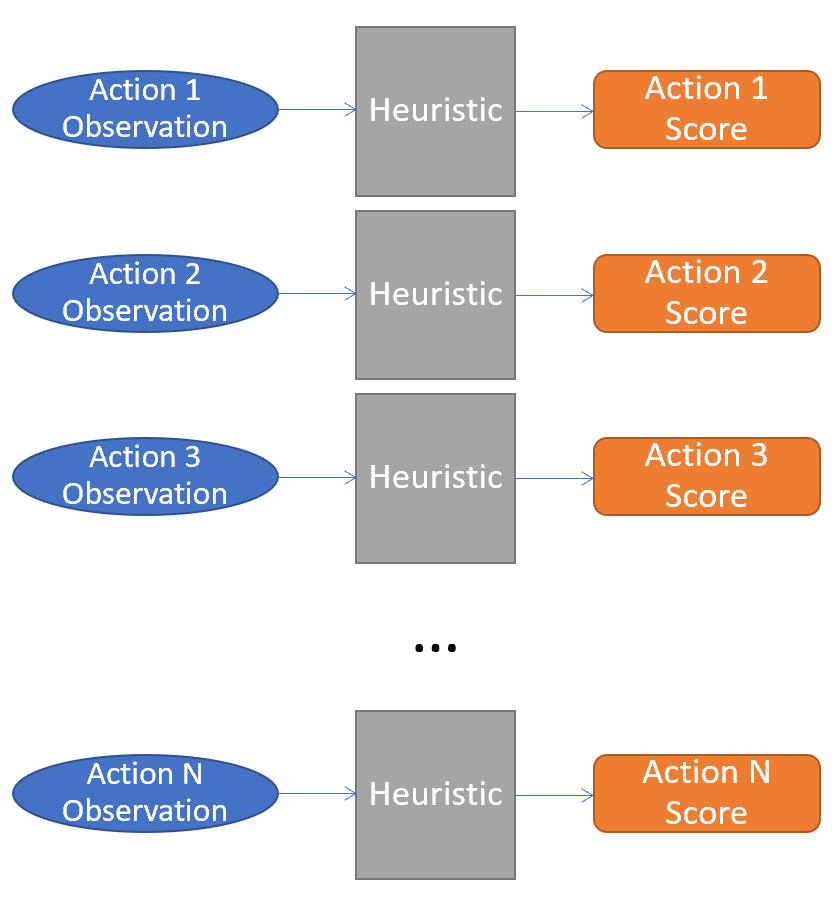

### Neural Network Setup
To begin, we'll first define the rough architecture of our network.  We'll be using a simple network architecture called a multi-layered Perceptron (MLP) with rectified Linear unit (ReLU) activation functions. It's not overly important to understand how that architecture works, but you are welcome to learn more by searching the aforementioned terms if interested. It is worth knowing, however, that there are hyperparameters describing the size of each network layer, the number of internal layers, and the number of outputs that affect the number of network parameters and the effectiveness of our optimization. It's also worth being aware that we're using the *JAX* framework, and its derivative tools/libraries *flax* and *linen*. JAX is a relatively new machine learning library developed by Google that offers JIT compilation, hardware acceleration, with features that simplify application of neuroevolution techniques, the implementation of vectorized operations, and parallelization across multiple hardware accelerators.

In [ ]:
class MLP(nn.Module):
    """Simple ReLU MLP"""

    num_hidden_units: int
    num_hidden_layers: int
    num_output_units: int

    @nn.compact
    def __call__(self, x):
        for l in range(self.num_hidden_layers):
            x = nn.Dense(features=self.num_hidden_units)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_output_units)(x)
        return x

In the cell below, we'll define a function to play Minesweeper with a neural network. We will pass an instantiation of our `MLP` class for the `network` argument, but otherwise you should be able to follow the function. You may notice that we flatten the per-action observation into a 1-dimensional array before passing it as input to our neural network. This is necessary for MLP layers and results in per-action observations of 1 dimension and containing 48 elements (a number you may see appear in later code).

In [ ]:
def neural_network_agent(game_map, network, params, enforce_reachability=True):
    env = MinesweeperGame(game_map, enforce_reachability=enforce_reachability)
    obs, score, done = env.reset()
    while not done:
        # evaluate network with provided parameters for each action
        action, best = None, None
        for action_idx, action_obs in enumerate(obs):
            action_score = network.apply(params, action_obs.flatten())[0]
            # select action with highest score
            if action == None or action_score > best:
                action = action_idx
                best = action_score
        obs, score, done = env.step(action)
    return score, env.player_map

### evosax

*evosax* is a library of JAX-based evolution strategies for neuroevolution. evosax contains a plethora of classic and modern optimization algorithms (called strategies) applicable to neuroevolution. Notably, this library introduces a common API usage that allows users to easily swap optimization strategies without needing to retool their high-level code. The API uses an `ask-eval-tell` loop (discussed in Deacon's lecture `AI for Uninitiated Colleagues` on 01/25/24) and a class for each optimization algorithm that implements the `ask` and `tell` methods in whatever way is appropriate for a given algorithm. In this way, a user can simply change which strategy is instantiated and the underlying code implementing the `ask-eval-tell` loop need not be modified. Neat!

To overcome an incompatibility of evosax and our `neural_network_agent` function, we'll begin this section by defining a function that reorganizes the population of parameters generated by evosax. Execute the following cell to define this function.

In [ ]:
def evosax_population_reformat(reshaped_params):
    pop_size = None
    for layer_key, layer in reshaped_params['params'].items():
        for param_key, params in layer.items():
            if pop_size == None:
                pop_size = params.shape[0]
            assert pop_size == params.shape[0], f'Encountered unexpected shape of {params.shape} at layer {layer_key}, given population size {pop_size}'
    population = [{'params': dict()} for _ in range(pop_size)]
    for ind_idx in range(pop_size):
        for layer_key, layer in reshaped_params['params'].items():
            population[ind_idx]['params'][layer_key] = {param_key: params[ind_idx] for param_key, params in layer.items()}
    return population

Now we'll define a function to perform a neuroevolution search. This function should implement the `ask-eval-tell` loop, utilize the `neural_network_agent` function defined previously, and return the best
`neural_network_agent` As a brief reminder of the `ask-eval-tell` loop:
* `ask` - generate multiple sets of neural network parameters as appropriate for the optimization strategy in use
* `eval` - evaluate the performance of each set of neural network parameters (this step is application-specific and thus not implemented by evosax)
* `tell` - use the performances of each set of neural network parameters to update internal mechanisms used to generate new parameters in the next `ask` step

The function we define for neuroevolution search should implement the `ask-eval-tell` loop. It's important to note that while we are providing this function to you, as it would be unreasonable to expect you to create it yourself, you should study it and understand what is happening from a high level. We'll elaborate on the input parameters momentarily, but try to infer their purpose and function for yourself first.

In [ ]:
def neuroevolution_search(game_map, strategy_cls, num_hidden_units, num_hidden_layers, population_size, generations, seed=42, enforce_reachability=True):
    # Seed rng (hard requirement in JAX)
    rng = jax.random.PRNGKey(seed)

    # Instantiate the model callables and get a placeholder pytree
    network = MLP(num_hidden_units=num_hidden_units, num_hidden_layers=num_hidden_layers, num_output_units=1)
    policy_params = network.init(rng, jnp.zeros(48,)) # input data size fixed by problem

    # Instantiate the reshape helper & get total number of parameters to reshape
    param_reshaper = ParameterReshaper(policy_params)

    # Instantiate the evolution strategy instance
    strategy = strategy_cls(num_dims=param_reshaper.total_params, popsize=100)
    
    # Get default hyperparameters (e.g. lrate, etc.)
    es_params = strategy.default_params
    
    # Initialize the strategy
    state = strategy.initialize(rng, es_params)
    
    # Define fitnes shaper to maximize fitness
    fit_shaper = FitnessShaper(centered_rank=True, z_score=False, w_decay=0.1, maximize=True)
    
    # JIT compile ask and tell steps
    ask = jax.jit(strategy.ask)
    tell = jax.jit(strategy.tell)
    
    best_score, best_solution, best_agent = None, None, None

    # loop for desired number of generations (+1 to account for initial generation being akin to random search)
    for gen in range(generations+1):
        # Ask for a set of candidate solutions to evaluate
        x, state = ask(rng, state, es_params)
        
        # Evaluate population
        reshaped_params = param_reshaper.reshape(x)
        population = evosax_population_reformat(reshaped_params)
        fitness = []
        for params in population:
            score, solution = neural_network_agent(game_map, network, params, enforce_reachability=enforce_reachability)
            fitness.append(score)
            if best_score == None or score > best_score:
                best_score = score
                best_solution = solution
                best_agent = params
        
        gen_best =  max(fitness)
        gen_avg = statistics.mean(fitness)
        print(f'generation {gen}/{generations}\tbest overall: {best_score:.6f}\tgen best: {gen_best:.6f}\tgen avg: {gen_avg:.6f}')
        shaped_fitness = fit_shaper.apply(x, np.array(fitness))
        
        # Tell performance of candidate solutions to strategy
        state = tell(x, shaped_fitness, state, es_params)
    return best_score, best_solution, best_agent

Now we'll call our `neuroevolution_search` function. As input, we pass the following hyperparameters:
* `game_map` - game map instance as in other similar functions.
* `strategy_cls` - the evosax strategy class we'll use for optimization (e.g., `evosax.CMA_ES`). See evosax documentation for other available strategies.
* `num_hidden_units` - size of internal neural network layers.
* `num_hidden_layers`- number of internal neural network layers.
* `population_size` - number of parameter sets generated in each generation of our search.
* `generations` - number of generations to search (note: an extra generation is added within the function)
* `seed` - RNG seed for JAX.
* `enforce_reachability` - calculates score based only on cells reachable from the starting location if `True`.

Calling this function will return the best score, the final state of the game corresponding with that score, and the parameters of the agent that generated the score. You'll be asked to use the agent parameters again later, so make note of the variable and take care not to accidentally overwrite it in later cells. *Evaluating the next cell may take a little time, but it should generate output during execution.*

In [ ]:
ne_beginner_results = neuroevolution_search(game_map=beginner_board, strategy_cls=evosax.CMA_ES, 
                                            num_hidden_units=48, num_hidden_layers=2, 
                                            population_size=100, generations=10, 
                                            seed=42, enforce_reachability=True
                                           )
ne_beginner, solution, ne_beginner_agent = ne_beginner_results

print('\nNeuroevolution agent final game state:')
render_map(solution, compact=False)

print('\n\t\tBeginner\tIntermediate')
print(f'BFS:\t\t{bfs_beginner:.6f}\t{bfs_intermediate:.6f}')
print(f'DFS:\t\t{dfs_beginner:.6f}\t{dfs_intermediate:.6f}')
print(f'Random (avg):\t{statistics.mean(beginner_scores):.6f}\t{statistics.mean(intermediate_scores):.6f}')
print(f'Random (max):\t{max(beginner_scores):.6f}\t{max(intermediate_scores):.6f}')
print(f'NE Agent:\t{ne_beginner:.6f}\tNA')

**Note**: for the following exercises, it's important to note that we have no set expectations or requirements about which algorithms outperform one another. For example, it's entirely possible that the best game of the random-action agent outperforms the best neuroevolution agent on a given problem.

## Exercise 1
In the following cell, implement the necessary code to perform a neuroevolution search using the `intermediate_board`. Save the best agent for analysis in a later task. Visualize the final board state of the best agent and print the performance results of all algorithms (i.e., replace the `NA` string from the last code cell). Feel free to use code from earlier in the notebook, but be careful not to accidentally overwrite variables.

In [ ]:
# implement Exercise 1 code here
pass

## Exercise 2
The following cell defines an expert-difficulty Minesweeper problem instance. Implement the necessary code to assess the performance of the `random-action` agent, across 5,000 games, on this problem and (in a separate cell) visualize the distribution of results using a boxplot. This boxplot should contain the performance distributions of the `random-action` agent on the `beginner`, `intermediate`, and `expert` problem instances. You are encouraged to reuse the boxplot visualization code from earlier in the notebook.

In [ ]:
expert_board = [
    [1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1],
    [0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0],
    [0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1],
    [0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
    [0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,1,0],
    [0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
    [0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0],
    [0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0],
    [0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0],
    [0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0],
    [0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0]
]

# evaluate random-action agent on expert_board
pass

In [ ]:
# visualize performance of random-action agent on beginner, intermadiate, and expert problem instances
pass

## Exercise 3
Implement the necessary code to assess the performance of the `bfs` and `dfs` agents on the `expert` problem instance. Visualize the final game state of both agents and save the performance data for use in a later exercise.

In [ ]:
# implement exercise 3 code here
pass

## Exercise 4
In the following cell, implement the necessary code to perform a neuroevolution search using the `expert_board`. Save the best agent for analysis in a later task. Visualize the final board state of the best agent and print the performance results of all algorithms on the expert-difficulty problem instance (i.e., print the results as in Exercise 1 with an additional column for the new problem instance). 

In [ ]:
# implement exercise 4 code here
pass

## Exercise 5
Assess the best neuroevolution agents for overfitting. We've now performed neuroevolution search using problem instances of three different difficulties and found a best agent during each search. Assess these agents on each problem instance so we can determine how they perform on instances outside those they were trained on. In a separate notebook cell, print the results in a table similar to Exercise 4 where each column corresponds to a problem instance and each row corresponds to an agent trained on a particular problem instance. If we were successful in generating agents that were decent at Minesweeper in general, they should perform well on all problem instances. If we encountered overfitting, then the agents will perform poorly on problem instances not encountered during training.

**Note**: you'll likely need to instantiate one or more `MLP` objects to serve as the `network` argument required by `neural_network_agent`. See the internal code of `neuroevolution_search` for an example of this.

In [ ]:
# evaluate neuroevolution agents on individual problem instances
pass

In [ ]:
# print agent performance results
pass

# Assignment 1b Preview
Assignment 1b is currently under development, but the current plan is for you to try and *break* a neuroevoltion agent trained by the TA by creating malicious Minesweeper game instances. Neuroevolution will make a return later in Assignment Series 1.